In [28]:
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import FrozenDict
import jax.numpy as jnp
import numpy as np

import jax
from jax import nn as jnn
from jax import random

from functools import partial

from flax import linen as nn
from flax import optim

import optax

import h5py
from fenics import *

from typing import Sequence

import matplotlib.pyplot as plt

import basix
from basix import ElementFamily, CellType, LagrangeVariant

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [29]:
def read_mesh_and_function(file_name, var_name):

    # Open solution file
    infile = XDMFFile(file_name + ".xdmf")
    infile_h5 = h5py.File(file_name + ".h5", "r")
    t_steps = len(infile_h5[var_name].keys())

    # Read in mesh
    mesh = Mesh()
    infile.read(mesh)

    # Read function
    V = FunctionSpace(mesh, "CG", 1)
    u = Function(V)
    solution = np.zeros((V.dim(), t_steps))
    for i in range(t_steps):
        infile.read_checkpoint(u, var_name, i - t_steps + 1)
        solution[:, i] = u.vector().get_local()

    # Clean up
    infile.close()
    infile_h5.close()

    return mesh, solution


nu = 0.001
A = 0.5
mesh, u_ref = read_mesh_and_function(
    "output/burgers_1D/nu_" + str(nu) + "/FOM", "u")
u_ref = u_ref.T

time_steps, N = u_ref.shape
u_train = u_ref[np.arange(0, time_steps, 5)]
n_train = len(u_train)
n = 15
M1 = 100
M2 = 100
n_epoch = 20000


class Encoder(nn.Module):
    latents: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.latents[0], dtype=jnp.float64,
                     param_dtype=jnp.float64)(x)
        x = nn.swish(x)
        xr = nn.Dense(n, dtype=jnp.float64, param_dtype=jnp.float64)(x)
        return xr


def gaussian_kernel(window_size, sigma):
    mu = window_size / 2
    x = jnp.arange(window_size)
    window = jnp.exp((-((x - mu)**2)) / (2 * sigma**2))
    window = window / jnp.sum(window)
    return window


@partial(jax.jit, static_argnums=1)
def dynamic_gaussian_smooth(x, window_size, sigmas):
    windows = jax.vmap(gaussian_kernel, in_axes=(None, 0))(window_size, sigmas)
    split_index = np.linspace(0, len(x), len(
        sigmas), endpoint=False, dtype=int)[1:]
    x_split = jnp.split(x, split_index)
    xs = []
    for i, window in enumerate(windows):
        xs.append(jnp.convolve(x_split[i], window, mode='same'))
    return jnp.hstack(xs)


class Decoder(nn.Module):
    latents: Sequence[int]

    def setup(self):
        n_sigmas = 5
        self.sigma = nn.Dense(n_sigmas, dtype=jnp.float64,
                          param_dtype=jnp.float64)

    @nn.compact
    def __call__(self, x):
        sigmas = self.sigma(x)
        x = nn.Dense(self.latents[0], dtype=jnp.float64,
                     param_dtype=jnp.float64)(x)
        x = nn.swish(x)
        x = nn.Dense(N, dtype=jnp.float64, param_dtype=jnp.float64)(x)

        window_size = int(len(x) / 10)
        x = dynamic_gaussian_smooth(x, window_size, sigmas)

        return x


class VAE(nn.Module):
    encoder_latents: Sequence[int]
    decoder_latents: Sequence[int]

    def setup(self):
        self.encoder = Encoder(self.encoder_latents)
        self.decoder = Decoder(self.decoder_latents)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def sigmas(self, x):
        return self.decoder.sigma(x)

    def __call__(self, x):
        return self.decode(self.encode(x))


def model():
    return VAE(encoder_latents=[M1], decoder_latents=[M2])

In [30]:
params = model().init(random.PRNGKey(0), u_train[0])
tx = optax.adam(0.001)
state = train_state.TrainState.create(apply_fn=model().apply,
                                      params=params,
                                      tx=tx)
CKPT_DIR = "nu_" + str(nu)
restored_state = checkpoints.restore_checkpoint(
    ckpt_dir=CKPT_DIR, target=state)
params = params.copy(restored_state.params)

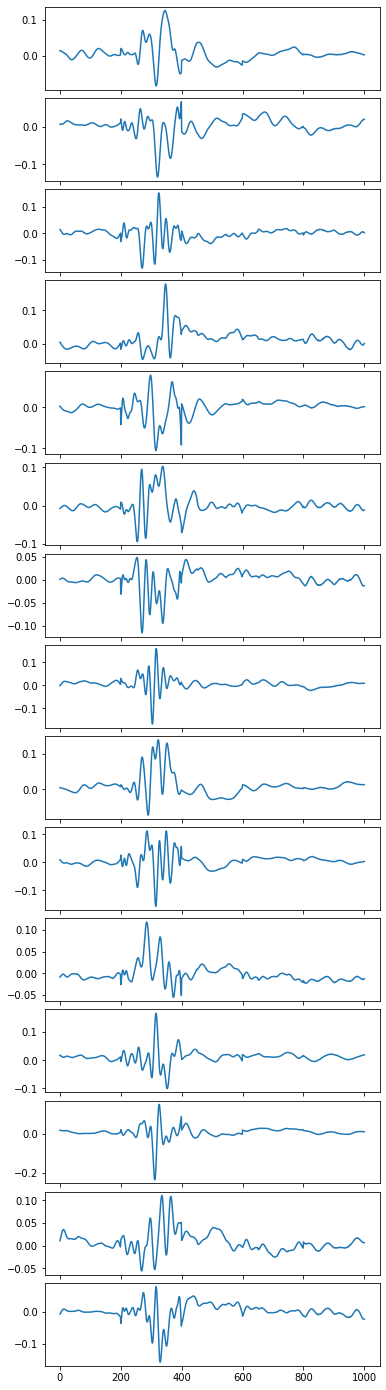

In [90]:
u_ref_encoded = model().apply(params, u_ref[400], method=VAE.encode)
Phi = jax.jacobian(model().apply, argnums=1)(params, u_ref_encoded, method=VAE.decode)
fig = plt.figure(figsize=(6, 25))
gs = fig.add_gridspec(n, 1, hspace=0.1)
axes = gs.subplots(sharex=True)
for i,ax in enumerate(axes):
    ax.plot(Phi.T[i])

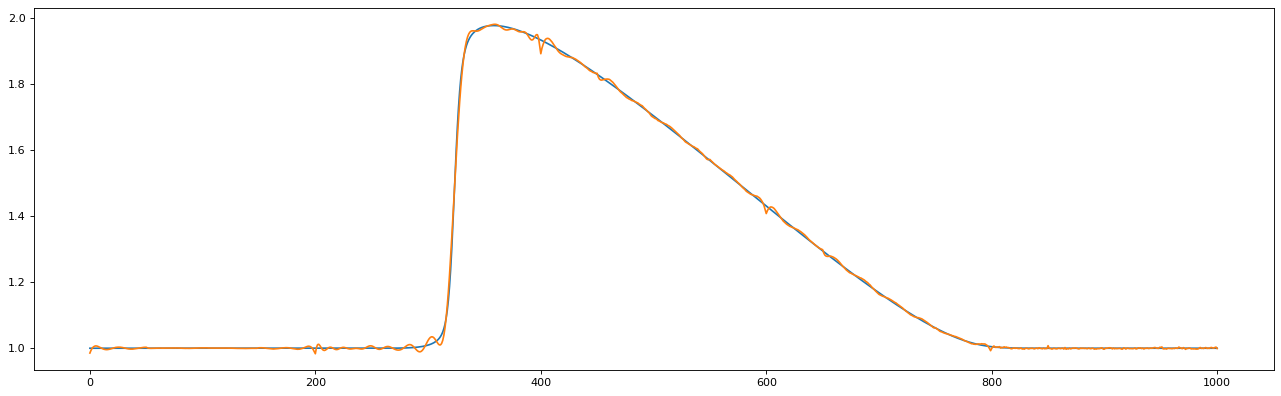

In [91]:
plt.figure(figsize=(20, 6), dpi=80)
u_peek = u_ref[400]
plt.plot(u_peek)
plt.plot(model().apply(params, u_peek))

In [33]:
t_start = 0.0
t_final = 0.5
dt = 0.001

V = FunctionSpace(mesh, "CG", 1)

In [34]:
nelem = mesh.num_cells()

# Per element
nqp = 2
ndof = 2
nvertex = 2
nnode = 2
ndim = 2

# Data structure to be computed per element
dof_map = np.zeros((nelem,ndof), dtype=int)
JxW = np.zeros((nelem,nqp))
grad_test = np.zeros((nelem,nqp,nnode,ndim))

lagrange = basix.create_element(ElementFamily.P, CellType.interval, 1, LagrangeVariant.equispaced)
ref_points, weights = basix.make_quadrature(CellType.interval, 2)
test, ref_grad_test = lagrange.tabulate(1, ref_points)
test = test.reshape(2,2)
ref_grad_test = ref_grad_test.reshape(2,2)

for e in range(nelem):
    cell = Cell(mesh, e)
    dof_map[e] = V.dofmap().cell_dofs(e)
    coordinates = np.array(cell.get_coordinate_dofs()).reshape(2,2)
    for qp,weight in enumerate(weights):
        J = jnp.matmul(ref_grad_test[qp], coordinates)
        detJ = jnp.sqrt(jnp.dot(J, J))
        JxW[e][qp] = detJ*weight
        grad_test[e][qp] = jnp.vstack((ref_grad_test[qp]/detJ, jnp.zeros((1,2)))).T

dof_map = jnp.array(dof_map)
JxW = jnp.array(JxW)
grad_test = jnp.array(grad_test)

In [35]:
def local_residual(dofs,JxW,test,grad_test,ut,ut_old,dt):
    local_re = jnp.zeros((N,))
    for i in range(nnode):
        r = 0
        for qp in range(nqp):
            u = jnp.dot(test[qp], ut[dofs])
            u_old = jnp.dot(test[qp], ut_old[dofs])
            grad_u = jnp.matmul(ut[dofs], grad_test[qp])
            r = r + (test[qp][i]*(u-u_old)/dt+nu*jnp.dot(grad_test[qp][i],grad_u)+test[qp][i]*grad_u[0]*u) * JxW[qp]
        local_re = local_re.at[dofs[i]].set(r)
    return local_re

In [36]:
def objective(ur, ur_old, dt, params):
    ut = model().apply(params, ur, method=VAE.decode)
    ut_old = model().apply(params, ur_old, method=VAE.decode)
    local_res = jax.vmap(local_residual, in_axes=(0,0,None,0,None,None,None), out_axes=0)(dof_map,JxW,test,grad_test,ut,ut_old,dt)
    r = jnp.sum(local_res,axis=0)
    return 0.5*jnp.dot(r,r)

residual = jax.jit(jax.value_and_grad(objective))

jacobian = jax.jit(jax.jacfwd(jax.grad(objective)))

# def residual(ur, ur_old, params):
#     ut = model().apply(params, ur, method=VAE.decode)
#     ut_old = model().apply(params, ur_old, method=VAE.decode)
#     local_res = jax.vmap(local_residual, in_axes=(0,0,None,0,None,None), out_axes=0)(dof_map,JxW,test,grad_test,ut,ut_old)
#     r = jnp.sum(local_res,axis=0)
#     return r

# jacobian = jax.jit(jax.jacfwd(residual))

In [37]:
u0 = Function(V)
u0_expr = Expression(
    "x[0] < 1 ? 1+A*(sin(2*pi*x[0]-pi/2)+1) : 1", degree=1, A=A)
u0.interpolate(u0_expr)

ur0 = model().apply(params, u0.vector().get_local(), method=VAE.encode)
ur = ur0
J = jacobian(ur, ur0, dt, params)

In [38]:
class Divergence(Exception):
    pass

def solve(u, u_old, dt, nl_max_its=10, RTOL=1e-6, ATOL=1e-8):
    def converged(r, r0):
        if jnp.linalg.norm(r) < ATOL:
            return True
        if jnp.linalg.norm(r) < RTOL * jnp.linalg.norm(r0):
            return True
        return False

    obj, r = residual(u, u_old, dt, params)
    r0 = r
    for itr in range(nl_max_its):
        print('Itr = {:}, |R| = {:.3E}, objective = {:.3E}'.format(itr, jnp.linalg.norm(r), obj))

        if converged(r, r0):
            return u
        
        J = jacobian(u, u_old, dt, params)

        du = - jnp.linalg.solve(J, r)
        u = u + du
        obj, r = residual(u, u_old, dt, params)

    raise Divergence

In [39]:
u0 = Function(V)
u0_expr = Expression(
    "x[0] < 1 ? 1+A*(sin(2*pi*x[0]-pi/2)+1) : 1", degree=1, A=A)
u0.interpolate(u0_expr)

ur0 = model().apply(params, u0.vector().get_local(), method=VAE.encode)
ur = ur0

def residual_helper(ur, ur_old, params):
    return np.array(residual(ur, ur_old, params))

def jacobian_helper(ur, ur_old, params):
    return np.array(jacobian(ur, ur_old, params))

from IPython.display import clear_output
import time

i = 0
t = t_start
ts = []
u_approx = []
while t < t_final:
    i = i + 1
    t = t + dt
    if i % 2 == 0:
        clear_output(wait=True)
    print('\nstep = {}, t = {}'.format(i, t))
    ur_old = np.array(ur)
    try:
        ur = solve(ur, ur_old, dt, nl_max_its=50, ATOL=1e-9)
    except Divergence:
        clear_output(wait=True)
        print('solve failed, cut dt')
        time.sleep(5)
        t = t - dt
        # Solve with half dt
        dt = dt / 2
        t = t + dt
        print('\nstep = {}, t = {}'.format(i, t))
        ur = solve(ur, ur_old, dt, nl_max_its=50, ATOL=1e-9)
        dt = dt * 2
        time.sleep(5)
    ts.append(t)
    u_approx.append(model().apply(params, ur, method=VAE.decode))


step = 500, t = 0.5000000000000003
Itr = 0, |R| = 5.807E-01, objective = 7.894E-02
Itr = 1, |R| = 4.381E-02, objective = 1.646E-02
Itr = 2, |R| = 9.277E-04, objective = 1.572E-02
Itr = 3, |R| = 7.261E-07, objective = 1.572E-02
Itr = 4, |R| = 6.344E-13, objective = 1.572E-02


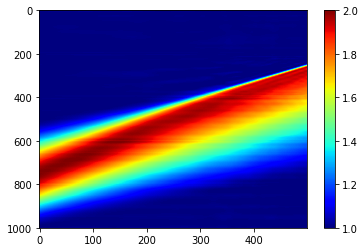

In [40]:
fig, ax = plt.subplots()
im = ax.imshow(np.array(u_approx).T, aspect='auto', cmap='jet', vmin=1, vmax=2)
cb = fig.colorbar(im)

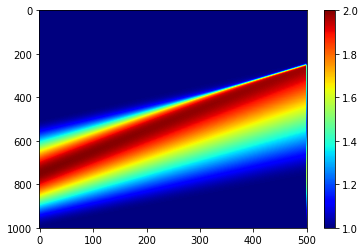

In [41]:
fig, ax = plt.subplots()
im = ax.imshow(u_ref.T, aspect='auto', cmap='jet', vmin=1, vmax=2)
cb = fig.colorbar(im)